# Walk-Forward Cross-Validation

This notebook demonstrates the walk-forward cross-validation setup for time series backtesting.

## Objectives:
1. Generate walk-forward splits with purging and embargo
2. Visualize train/validation/test periods
3. Validate no data leakage between folds
4. Examine split statistics

**Note**: Walk-forward CV prevents look-ahead bias in time series modeling!

In [1]:
# Setup
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from src.utils.config import ConfigLoader
from src.data.splitter import WalkForwardSplitter, SimpleSplitter
from src.utils.visualizations import plot_walk_forward_splits

# Style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ Imports successful")

✓ Imports successful


## 1. Load Configuration and Data

In [2]:
# Load configs
config_loader = ConfigLoader('../config')
cv_config = config_loader.load('cv_config')

print("Walk-Forward Configuration:")
print(f"  Train window: {cv_config['walk_forward']['train_window_days']} days")
print(f"  Validation window: {cv_config['walk_forward']['val_window_days']} days")
print(f"  Step size: {cv_config['walk_forward']['step_days']} days")
print(f"  Purge days: {cv_config['walk_forward']['purge_days']} days")
print(f"  Embargo days: {cv_config['walk_forward']['embargo_days']} days")
print(f"\nTest Configuration:")
print(f"  Test start date: {cv_config['test_set']['start_date']}")
print(f"  Test end date: {cv_config['test_set']['end_date']}")

# Load featured data
data = pd.read_parquet('../data/features/featured_data.parquet')
print(f"\n✓ Loaded {len(data)} rows")
print(f"  Date range: {data.index.min()} to {data.index.max()}")

if 'ticker' in data.columns:
    print(f"  Tickers: {list(data['ticker'].unique())}")

INFO:src.utils.config:Loaded config: cv_config


Walk-Forward Configuration:
  Train window: 1095 days
  Validation window: 180 days
  Step size: 90 days
  Purge days: 5 days
  Embargo days: 5 days

Test Configuration:
  Test start date: 2019-01-01
  Test end date: 2024-12-31

✓ Loaded 19452 rows
  Date range: 2005-09-02 00:00:00 to 2024-12-30 00:00:00
  Tickers: ['QQQ', 'SPY', 'TLT', 'GLD']


## 2. Generate Walk-Forward Splits

The walk-forward splitter creates rolling windows with:
- **Training window**: Historical data for model training
- **Validation window**: Out-of-sample data for hyperparameter tuning
- **Purge period**: Gap before validation to prevent autocorrelation
- **Embargo period**: Gap after validation to prevent look-ahead

In [3]:
# Initialize splitter
print("Generating walk-forward splits...\n")
splitter = WalkForwardSplitter(cv_config)

# Generate splits
splits = splitter.split(data)

print(f"✓ Generated {len(splits)} walk-forward splits")
print(f"\nSplit details:")
for split in splits:
    print(f"  Fold {split.fold}: Train {split.train_start} to {split.train_end}, "
          f"Val {split.val_start} to {split.val_end}")

INFO:src.data.splitter:Generated 40 walk-forward splits


Generating walk-forward splits...

✓ Generated 40 walk-forward splits

Split details:
  Fold 0: Train 2005-09-02 00:00:00 to 2008-08-29 00:00:00, Val 2008-09-11 00:00:00 to 2009-03-10 00:00:00
  Fold 1: Train 2005-12-01 00:00:00 to 2008-11-28 00:00:00, Val 2008-12-10 00:00:00 to 2009-06-08 00:00:00
  Fold 2: Train 2006-03-01 00:00:00 to 2009-02-27 00:00:00, Val 2009-03-10 00:00:00 to 2009-09-04 00:00:00
  Fold 3: Train 2006-05-30 00:00:00 to 2009-05-29 00:00:00, Val 2009-06-08 00:00:00 to 2009-12-04 00:00:00
  Fold 4: Train 2006-08-28 00:00:00 to 2009-08-27 00:00:00, Val 2009-09-08 00:00:00 to 2010-03-05 00:00:00
  Fold 5: Train 2006-11-27 00:00:00 to 2009-11-25 00:00:00, Val 2009-12-07 00:00:00 to 2010-06-03 00:00:00
  Fold 6: Train 2007-02-26 00:00:00 to 2010-02-23 00:00:00, Val 2010-03-05 00:00:00 to 2010-09-01 00:00:00
  Fold 7: Train 2007-05-25 00:00:00 to 2010-05-24 00:00:00, Val 2010-06-03 00:00:00 to 2010-11-30 00:00:00
  Fold 8: Train 2007-08-23 00:00:00 to 2010-08-20 00:00:00

## 3. Split Summary Statistics

In [4]:
# Get summary table
summary = splitter.summary(splits)

print("\nSplit Summary Table:")
print(summary.to_string(index=False))

# Calculate statistics
print(f"\nStatistics:")
print(f"  Total folds: {len(summary)}")
print(f"  Avg train days: {summary['train_days'].mean():.0f}")
print(f"  Avg val days: {summary['val_days'].mean():.0f}")
print(f"  Total date range: {summary['train_start'].min()} to {summary['val_end'].max()}")


Split Summary Table:
 fold train_start  train_end  val_start    val_end  train_days  val_days  gap_days
    0  2005-09-02 2008-08-29 2008-09-11 2009-03-10        1092       180        13
    1  2005-12-01 2008-11-28 2008-12-10 2009-06-08        1093       180        12
    2  2006-03-01 2009-02-27 2009-03-10 2009-09-04        1094       178        11
    3  2006-05-30 2009-05-29 2009-06-08 2009-12-04        1095       179        10
    4  2006-08-28 2009-08-27 2009-09-08 2010-03-05        1095       178        12
    5  2006-11-27 2009-11-25 2009-12-07 2010-06-03        1094       178        12
    6  2007-02-26 2010-02-23 2010-03-05 2010-09-01        1093       180        10
    7  2007-05-25 2010-05-24 2010-06-03 2010-11-30        1095       180        10
    8  2007-08-23 2010-08-20 2010-09-01 2011-02-28        1093       180        12
    9  2007-11-21 2010-11-19 2010-11-30 2011-05-27        1094       178        11
   10  2008-02-19 2011-02-18 2011-02-28 2011-08-26        1095   

## 4. Visualize Walk-Forward Splits

Timeline visualization showing train/validation periods for each fold.

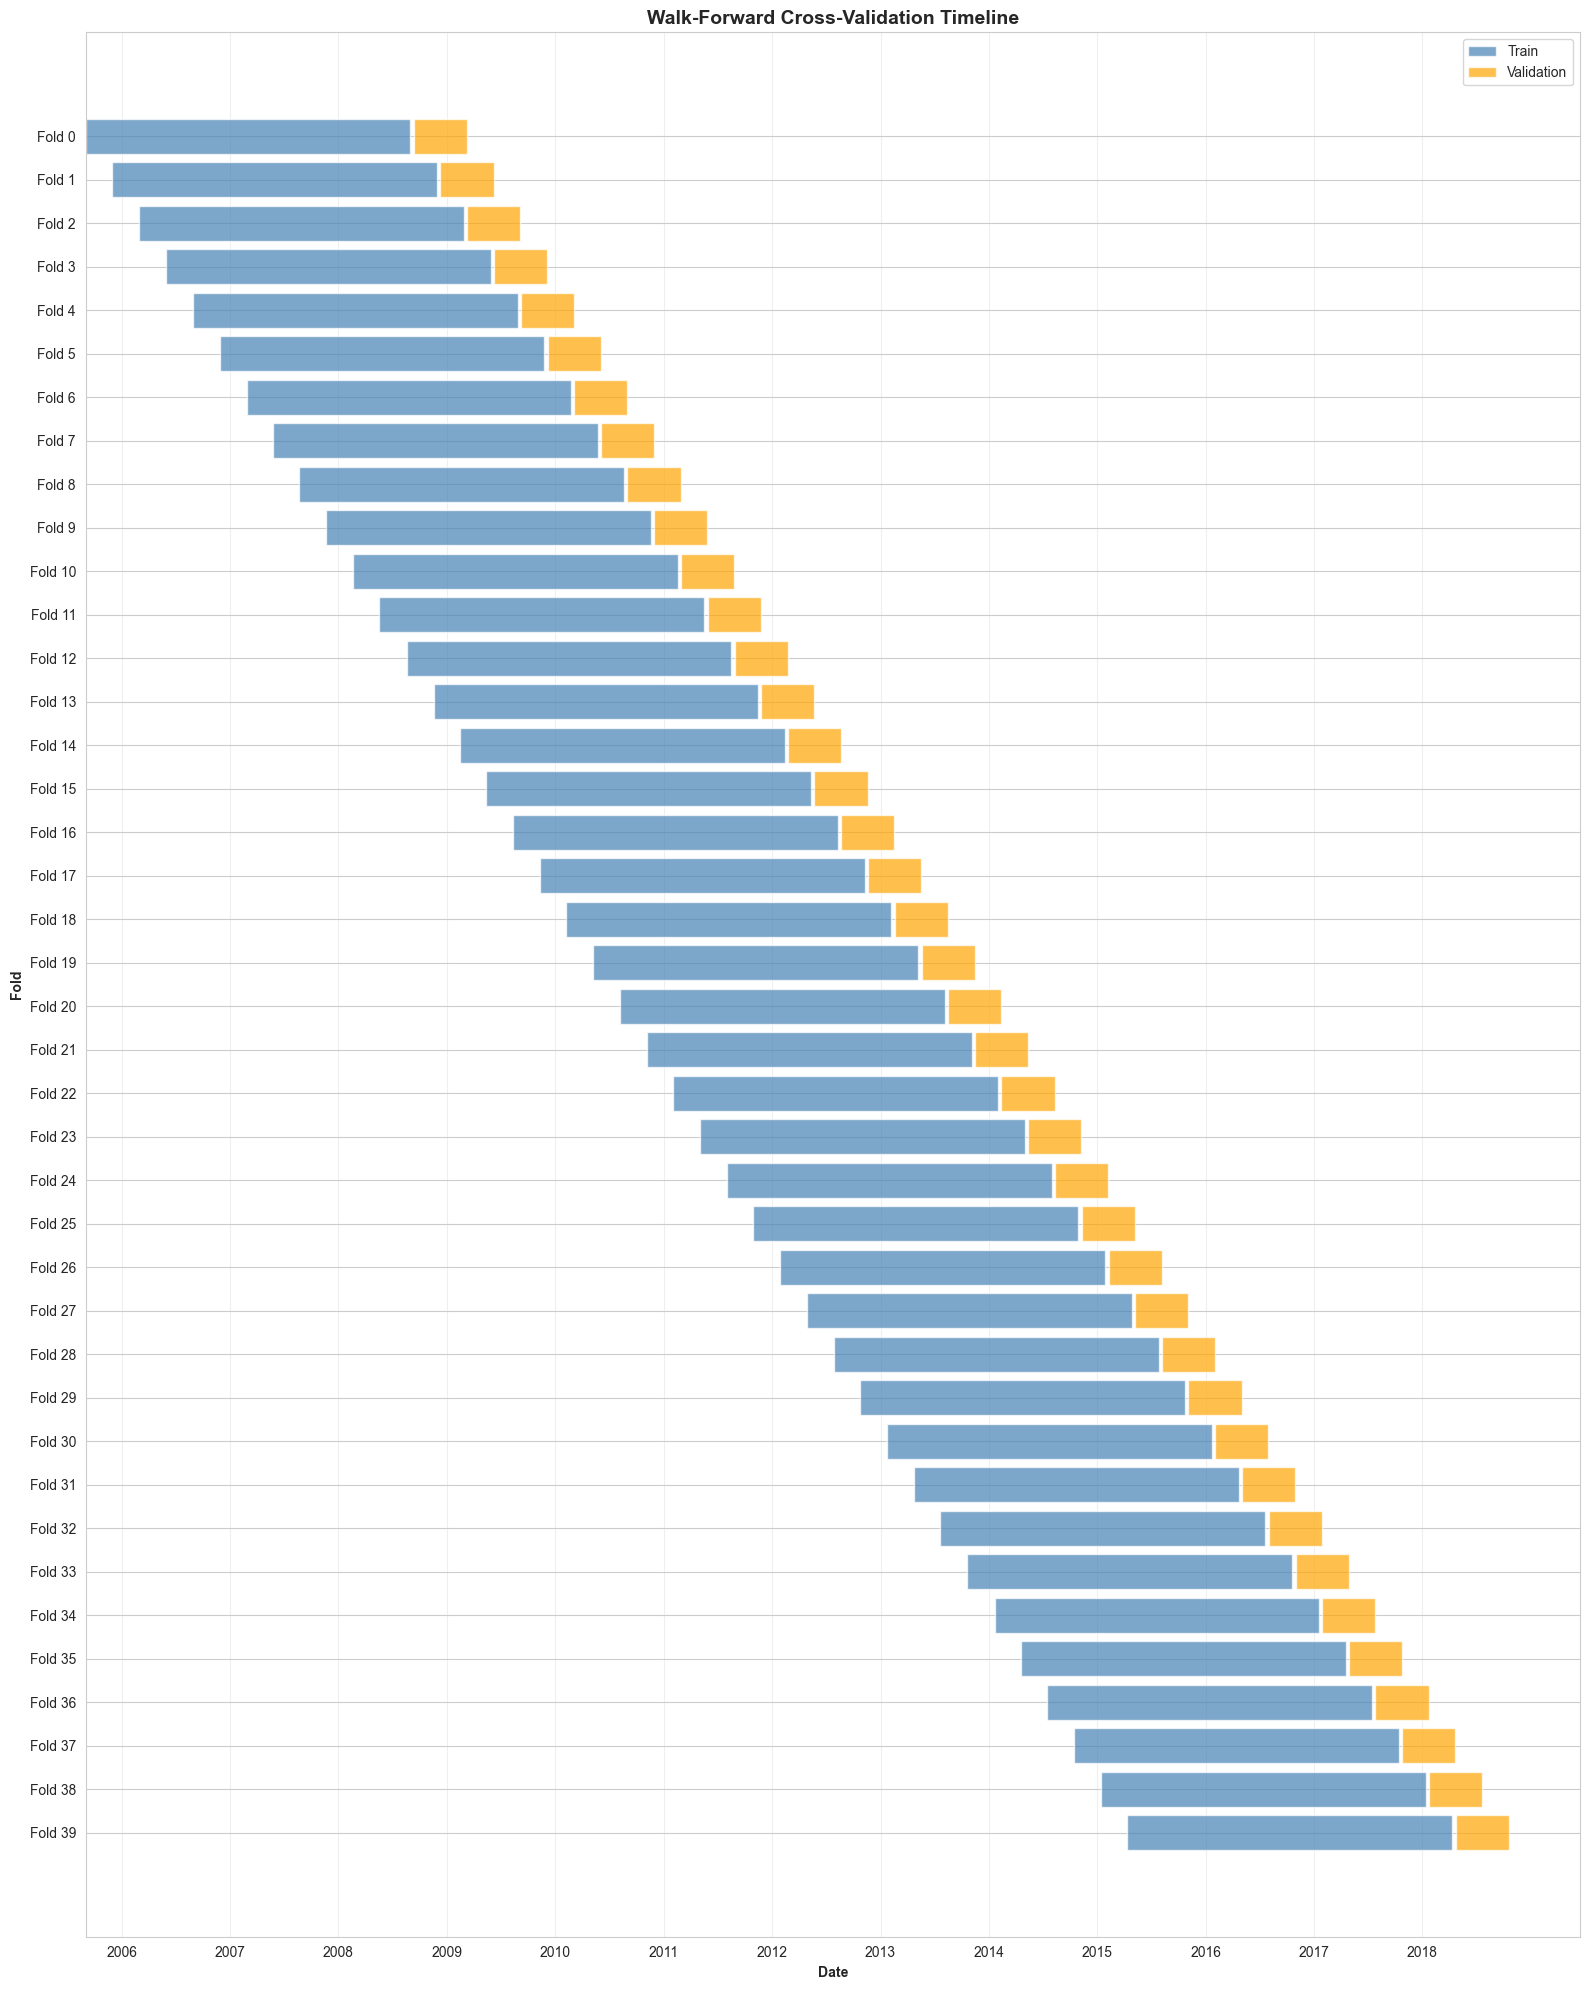

In [5]:
# Create timeline visualization
fig, ax = plt.subplots(figsize=(16, max(8, len(splits) * 0.5)))

for idx, split in enumerate(splits):
    y_pos = len(splits) - idx
    
    # Plot train period
    train_start = pd.to_datetime(split.train_start)
    train_end = pd.to_datetime(split.train_end)
    ax.barh(y_pos, (train_end - train_start).days, left=train_start.toordinal(), 
            height=0.8, color='steelblue', alpha=0.7, label='Train' if idx == 0 else '')
    
    # Plot validation period
    val_start = pd.to_datetime(split.val_start)
    val_end = pd.to_datetime(split.val_end)
    ax.barh(y_pos, (val_end - val_start).days, left=val_start.toordinal(), 
            height=0.8, color='orange', alpha=0.7, label='Validation' if idx == 0 else '')

# Format x-axis as dates
all_dates = pd.date_range(
    pd.to_datetime(splits[0].train_start),
    pd.to_datetime(splits[-1].val_end),
    freq='YS'
)
ax.set_xticks([d.toordinal() for d in all_dates])
ax.set_xticklabels([d.strftime('%Y') for d in all_dates])

# Labels and formatting
ax.set_yticks(range(1, len(splits) + 1))
ax.set_yticklabels([f'Fold {i}' for i in range(len(splits) - 1, -1, -1)])
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Fold', fontweight='bold')
ax.set_title('Walk-Forward Cross-Validation Timeline', fontweight='bold', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 5. Test Set Analysis

In [6]:
# Get test set
test_data = splitter.get_test_data(data)

print(f"Test Set:")
print(f"  Rows: {len(test_data):,}")
print(f"  Date range: {test_data.index.min()} to {test_data.index.max()}")
print(f"  % of total data: {len(test_data) / len(data) * 100:.1f}%")

if 'ticker' in test_data.columns:
    print(f"\nRows per ticker in test set:")
    for ticker in test_data['ticker'].unique():
        ticker_rows = len(test_data[test_data['ticker'] == ticker])
        print(f"  {ticker}: {ticker_rows:,} rows")

INFO:src.data.splitter:Test set: 6036 samples from 2019-01-01 to 2024-12-31


Test Set:
  Rows: 6,036
  Date range: 2019-01-02 00:00:00 to 2024-12-30 00:00:00
  % of total data: 31.0%

Rows per ticker in test set:
  QQQ: 1,509 rows
  SPY: 1,509 rows
  TLT: 1,509 rows
  GLD: 1,509 rows


## 6. Validate No Data Leakage

Critical check: Ensure no overlap between train/validation and test sets.

In [7]:
# Check for overlap between train/val and test
test_dates = set(test_data.index.unique())

print("Checking for data leakage...\n")
overlap_found = False

for split in splits:
    train_data, val_data = splitter.get_train_val_data(data, split)
    
    train_dates = set(train_data.index.unique())
    val_dates = set(val_data.index.unique())
    
    # Check train overlap
    train_overlap = train_dates & test_dates
    if train_overlap:
        print(f"⚠️  WARNING: Fold {split.fold} train overlaps with test by {len(train_overlap)} dates!")
        overlap_found = True
    
    # Check validation overlap
    val_overlap = val_dates & test_dates
    if val_overlap:
        print(f"⚠️  WARNING: Fold {split.fold} validation overlaps with test by {len(val_overlap)} dates!")
        overlap_found = True

if not overlap_found:
    print("✓ No data leakage detected!")
    print("  All train/validation sets are properly separated from test set")

INFO:src.data.splitter:Fold 0: Train=3012 rows, Val=496 rows
INFO:src.data.splitter:Fold 1: Train=3016 rows, Val=492 rows
INFO:src.data.splitter:Fold 2: Train=3020 rows, Val=504 rows
INFO:src.data.splitter:Fold 3: Train=3024 rows, Val=508 rows
INFO:src.data.splitter:Fold 4: Train=3024 rows, Val=496 rows
INFO:src.data.splitter:Fold 5: Train=3024 rows, Val=492 rows
INFO:src.data.splitter:Fold 6: Train=3020 rows, Val=504 rows
INFO:src.data.splitter:Fold 7: Train=3020 rows, Val=504 rows
INFO:src.data.splitter:Fold 8: Train=3020 rows, Val=496 rows
INFO:src.data.splitter:Fold 9: Train=3024 rows, Val=500 rows
INFO:src.data.splitter:Fold 10: Train=3036 rows, Val=508 rows
INFO:src.data.splitter:Fold 11: Train=3032 rows, Val=504 rows
INFO:src.data.splitter:Fold 12: Train=3028 rows, Val=492 rows
INFO:src.data.splitter:Fold 13: Train=3024 rows, Val=496 rows
INFO:src.data.splitter:Fold 14: Train=3024 rows, Val=504 rows
INFO:src.data.splitter:Fold 15: Train=3024 rows, Val=496 rows
INFO:src.data.spli

Checking for data leakage...

✓ No data leakage detected!
  All train/validation sets are properly separated from test set


## 7. Examine Sample Fold Data

Look at the actual data for the first fold to verify everything is correct.

In [8]:
# Get data for first fold
if len(splits) > 0:
    fold_0 = splits[0]
    train_data, val_data = splitter.get_train_val_data(data, fold_0)
    
    print(f"Fold 0 Details:")
    print(f"\nTraining Set:")
    print(f"  Rows: {len(train_data):,}")
    print(f"  Date range: {train_data.index.min()} to {train_data.index.max()}")
    print(f"  Days: {(train_data.index.max() - train_data.index.min()).days}")
    
    print(f"\nValidation Set:")
    print(f"  Rows: {len(val_data):,}")
    print(f"  Date range: {val_data.index.min()} to {val_data.index.max()}")
    print(f"  Days: {(val_data.index.max() - val_data.index.min()).days}")
    
    # Check gap between train and validation
    gap_days = (val_data.index.min() - train_data.index.max()).days
    print(f"\nGap between train and validation: {gap_days} days")
    print(f"  (Configured purge: {cv_config['walk_forward']['purge_days']} days)")
    
    # Show sample data
    print(f"\nSample from training set (first 5 rows):")
    print(train_data.head())

INFO:src.data.splitter:Fold 0: Train=3012 rows, Val=496 rows


Fold 0 Details:

Training Set:
  Rows: 3,012
  Date range: 2005-09-02 00:00:00 to 2008-08-29 00:00:00
  Days: 1092

Validation Set:
  Rows: 496
  Date range: 2008-09-11 00:00:00 to 2009-03-10 00:00:00
  Days: 180

Gap between train and validation: 13 days
  (Configured purge: 5 days)

Sample from training set (first 5 rows):
                 open       high        low      close      volume ticker  \
date                                                                        
2005-09-02  33.342517  33.368164  33.120235  33.145882  53244900.0    QQQ   
2005-09-06  33.299762  33.693032  33.257016  33.633186  78106600.0    QQQ   
2005-09-07  33.598995  33.752884  33.522051  33.693039  57440100.0    QQQ   
2005-09-08  33.590431  33.829812  33.573332  33.684475  73529700.0    QQQ   
2005-09-09  33.693038  33.932419  33.607546  33.872574  75342100.0    QQQ   

            return_1d  return_3d  return_5d  return_10d  ...          obv  \
date                                                    

## 8. Compare SimpleSplitter

Compare with simple train/val/test split (no walk-forward).

In [9]:
# Create simple splitter
simple_splitter = SimpleSplitter(cv_config)

# Get simple splits (returns all three at once)
train_simple, val_simple, test_simple = simple_splitter.split(data)

print("Simple Split (No Walk-Forward):")
print(f"\nTrain:")
print(f"  Rows: {len(train_simple):,}")
print(f"  Date range: {train_simple.index.min()} to {train_simple.index.max()}")

print(f"\nValidation:")
print(f"  Rows: {len(val_simple):,}")
print(f"  Date range: {val_simple.index.min()} to {val_simple.index.max()}")

print(f"\nTest:")
print(f"  Rows: {len(test_simple):,}")
print(f"  Date range: {test_simple.index.min()} to {test_simple.index.max()}")

print(f"\n\nComparison:")
print(f"  Walk-forward: {len(splits)} folds with rolling windows")
print(f"  Simple split: 1 static train/val/test split")
print(f"\n  Walk-forward is more robust for time series modeling!")

INFO:src.data.splitter:Simple split: Train=9388, Val=2012, Test=6036


Simple Split (No Walk-Forward):

Train:
  Rows: 9,388
  Date range: 2005-09-02 00:00:00 to 2014-12-30 00:00:00

Validation:
  Rows: 2,012
  Date range: 2014-12-31 00:00:00 to 2016-12-28 00:00:00

Test:
  Rows: 6,036
  Date range: 2019-01-02 00:00:00 to 2024-12-30 00:00:00


Comparison:
  Walk-forward: 40 folds with rolling windows
  Simple split: 1 static train/val/test split

  Walk-forward is more robust for time series modeling!


## 9. Purge and Embargo Visualization

Visualize the purge and embargo periods to understand how they prevent leakage.

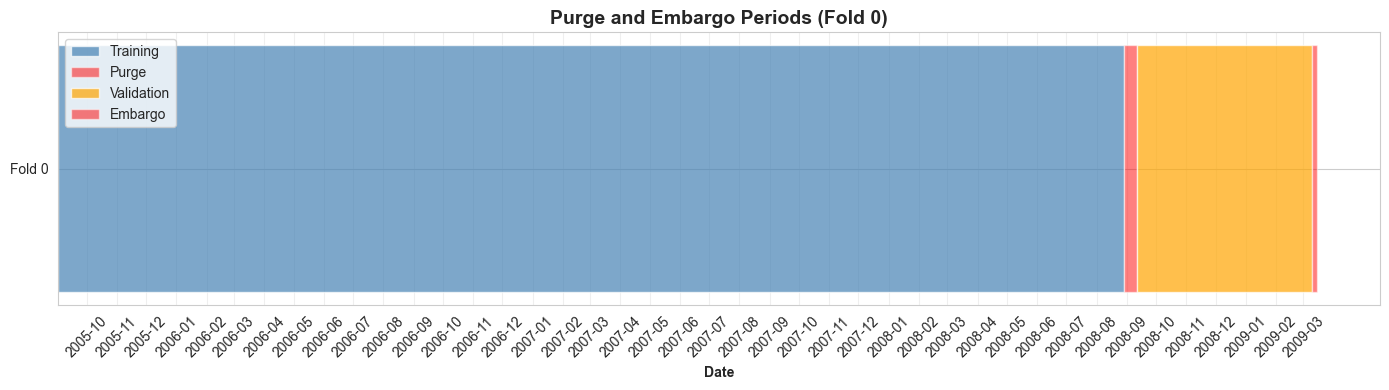


Purge Period: 13 days
  Prevents autocorrelation from training leaking into validation

Embargo Period: 5 days
  Prevents information from validation leaking into future folds


In [10]:
# Visualize purge/embargo for first fold
if len(splits) > 0:
    fold_0 = splits[0]
    
    fig, ax = plt.subplots(figsize=(14, 4))
    
    # Dates
    train_start = pd.to_datetime(fold_0.train_start)
    train_end = pd.to_datetime(fold_0.train_end)
    val_start = pd.to_datetime(fold_0.val_start)
    val_end = pd.to_datetime(fold_0.val_end)
    
    # Calculate purge/embargo periods
    purge_start = train_end
    purge_end = val_start
    embargo_start = val_end
    embargo_end = val_end + pd.Timedelta(days=cv_config['walk_forward']['embargo_days'])
    
    # Plot periods
    ax.barh(1, (train_end - train_start).days, left=train_start.toordinal(), 
            height=0.6, color='steelblue', alpha=0.7, label='Training')
    ax.barh(1, (purge_end - purge_start).days, left=purge_start.toordinal(), 
            height=0.6, color='red', alpha=0.5, label='Purge')
    ax.barh(1, (val_end - val_start).days, left=val_start.toordinal(), 
            height=0.6, color='orange', alpha=0.7, label='Validation')
    ax.barh(1, (embargo_end - embargo_start).days, left=embargo_start.toordinal(), 
            height=0.6, color='red', alpha=0.5, label='Embargo')
    
    # Format x-axis
    date_range = pd.date_range(train_start, embargo_end, freq='MS')
    ax.set_xticks([d.toordinal() for d in date_range])
    ax.set_xticklabels([d.strftime('%Y-%m') for d in date_range], rotation=45)
    
    # Labels
    ax.set_yticks([1])
    ax.set_yticklabels(['Fold 0'])
    ax.set_xlabel('Date', fontweight='bold')
    ax.set_title('Purge and Embargo Periods (Fold 0)', fontweight='bold', fontsize=14)
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nPurge Period: {(purge_end - purge_start).days} days")
    print(f"  Prevents autocorrelation from training leaking into validation")
    print(f"\nEmbargo Period: {(embargo_end - embargo_start).days} days")
    print(f"  Prevents information from validation leaking into future folds")

## Summary

In this notebook, we:
1. ✓ Generated walk-forward cross-validation splits
2. ✓ Visualized train/validation/test periods on a timeline
3. ✓ Validated no data leakage between folds and test set
4. ✓ Examined purge and embargo periods to prevent autocorrelation
5. ✓ Compared walk-forward with simple static splits

**Key Takeaways**:
- Walk-forward CV provides robust evaluation for time series models
- Purge periods prevent autocorrelation from training leaking into validation
- Embargo periods prevent information leakage into future folds
- Test set is properly held out and never used during training/validation

**Ready for Phase 2**: The data infrastructure is complete and validated!

**Next Steps**:
1. Implement TimingAgent with DQN
2. Train on walk-forward splits
3. Evaluate on held-out test set